# Perceptron Comparison: Single-Layer vs Multi-Layer

This notebook compares the performance of a Single-Layer Perceptron and a Multi-Layer Perceptron on the Iris dataset.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

## Data Preparation

In [23]:
# Load data
data = pd.read_csv('iris.csv')
data.columns = ['Sepal_len_cm','Sepal_wid_cm','Petal_len_cm','Petal_wid_cm','Type']
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (149, 5)


,Sepal_len_cm,Sepal_wid_cm,Petal_len_cm,Petal_wid_cm,Type
0,4.9,3.0,1.4,0.2,0
1,4.7,3.2,1.3,0.2,0
2,4.6,3.1,1.5,0.2,0
3,5.0,3.6,1.4,0.2,0
4,5.4,3.9,1.7,0.4,0


In [24]:
# Prepare features and labels
X = data.drop('Type', axis=1).values
y = data['Type'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (104, 4) (104,)
Testing set shape: (45, 4) (45,)


## Single-Layer Perceptron Implementation

Based on the implementation from the single_layer_perceptrons.ipynb notebook.

In [25]:
def activation_func(value):
    # Tangent Hypotenuse (tanh)
    return np.tanh(value)

def perceptron_train(X, y, alpha=0.01, epochs=100):
    weights = np.random.random(X.shape[1])
    bias = np.random.random_sample()
    
    for epoch in range(epochs):
        for i in range(X.shape[0]):
            # Forward pass
            a = activation_func(np.dot(weights, X[i]) + bias)
            
            # Convert continuous output to discrete classes
            yn = 0
            if a >= 0.7:
                yn = 1
            elif a <= (-0.7):
                yn = -1
            
            # Update weights
            weights = weights + alpha * (yn - y[i]) * X[i]
            bias = bias + alpha * (yn - y[i])
    
    return weights, bias

def perceptron_predict(X, weights, bias):
    predictions = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        a = activation_func(np.dot(weights, X[i]) + bias)
        if a >= 0.7:
            predictions[i] = 1
        elif a <= -0.7:
            predictions[i] = -1
        else:
            predictions[i] = 0
    return predictions

## Multi-Layer Perceptron Implementation

In [26]:
class MultiLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.1
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.1
        self.b2 = np.zeros((1, self.output_size))
        
    def sigmoid(self, x):
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, X):
        # Forward propagation
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, output):
        # Backward propagation
        m = X.shape[0]
        
        # Calculate gradients
        dZ2 = output - y
        dW2 = (1/m) * np.dot(self.a1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.a1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
        # Update weights and biases
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def train(self, X, y, epochs):
        self.losses = []
        
        # Convert labels to one-hot encoding
        y_one_hot = self.to_one_hot(y)
        
        for i in range(epochs):
            # Forward propagation
            output = self.forward(X)
            
            # Calculate loss (Mean Squared Error)
            loss = np.mean((output - y_one_hot) ** 2)
            self.losses.append(loss)
            
            # Backward propagation
            self.backward(X, y_one_hot, output)
    
    def to_one_hot(self, labels):
        n_classes = len(np.unique([-1, 0, 1]))  # We know we have 3 classes
        one_hot = np.zeros((labels.shape[0], n_classes))
        for i, label in enumerate(labels):
            if label == -1:  # First class
                one_hot[i, 0] = 1
            elif label == 0:  # Second class
                one_hot[i, 1] = 1
            else:  # Third class (label == 1)
                one_hot[i, 2] = 1
        return one_hot
    
    def from_one_hot(self, one_hot):
        return np.argmax(one_hot, axis=1) - 1  # Convert back to -1, 0, 1
    
    def predict(self, X):
        output = self.forward(X)
        # Convert probabilities to class predictions
        return self.from_one_hot(output)

## Training Both Models

In [27]:
# Train Single-Layer Perceptron
print("Training Single-Layer Perceptron...")
slp_weights, slp_bias = perceptron_train(X_train_scaled, y_train, alpha=0.01, epochs=100)

# Train Multi-Layer Perceptron
print("Training Multi-Layer Perceptron...")
mlp = MultiLayerPerceptron(input_size=4, hidden_size=10, output_size=3, learning_rate=0.5)
mlp.train(X_train_scaled, y_train, epochs=1000)

Training Single-Layer Perceptron...
Training Multi-Layer Perceptron...


## Evaluation

In [28]:
# Predictions
slp_train_pred = perceptron_predict(X_train_scaled, slp_weights, slp_bias)
slp_test_pred = perceptron_predict(X_test_scaled, slp_weights, slp_bias)

mlp_train_pred = mlp.predict(X_train_scaled)
mlp_test_pred = mlp.predict(X_test_scaled)

# Calculate accuracies
slp_train_accuracy = accuracy_score(y_train, slp_train_pred)
slp_test_accuracy = accuracy_score(y_test, slp_test_pred)

mlp_train_accuracy = accuracy_score(y_train, mlp_train_pred)
mlp_test_accuracy = accuracy_score(y_test, mlp_test_pred)

print("=== MODEL COMPARISON ===")
print("\nSingle-Layer Perceptron:")
print(f"  Training Accuracy: {slp_train_accuracy * 100:.2f}%")
print(f"  Testing Accuracy:  {slp_test_accuracy * 100:.2f}%")

print("\nMulti-Layer Perceptron:")
print(f"  Training Accuracy: {mlp_train_accuracy * 100:.2f}%")
print(f"  Testing Accuracy:  {mlp_test_accuracy * 100:.2f}%")

print(f"\nImprovement with MLP: {(mlp_test_accuracy - slp_test_accuracy) * 100:.2f}% points")

=== MODEL COMPARISON ===

Single-Layer Perceptron:
  Training Accuracy: 35.58%
  Testing Accuracy:  28.89%

Multi-Layer Perceptron:
  Training Accuracy: 100.00%
  Testing Accuracy:  93.33%

Improvement with MLP: 64.44% points


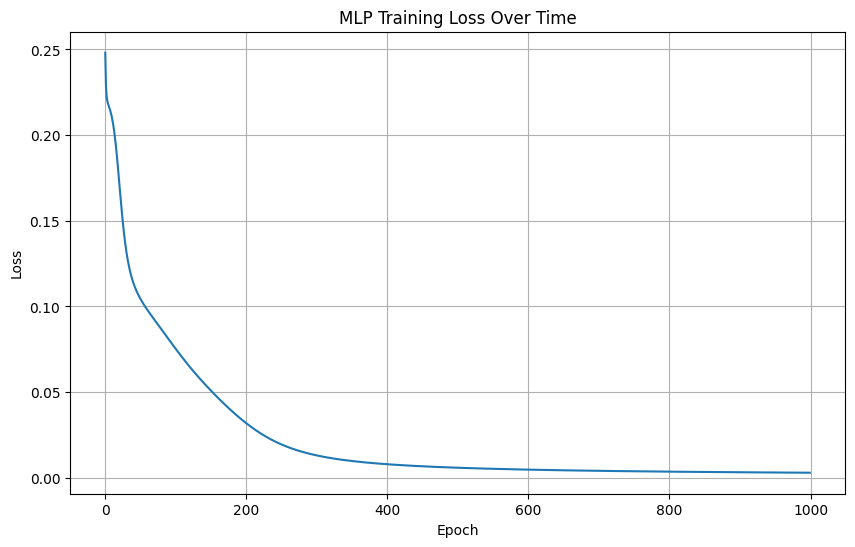

In [29]:
# Plot training loss for MLP
plt.figure(figsize=(10, 6))
plt.plot(mlp.losses)
plt.title('MLP Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

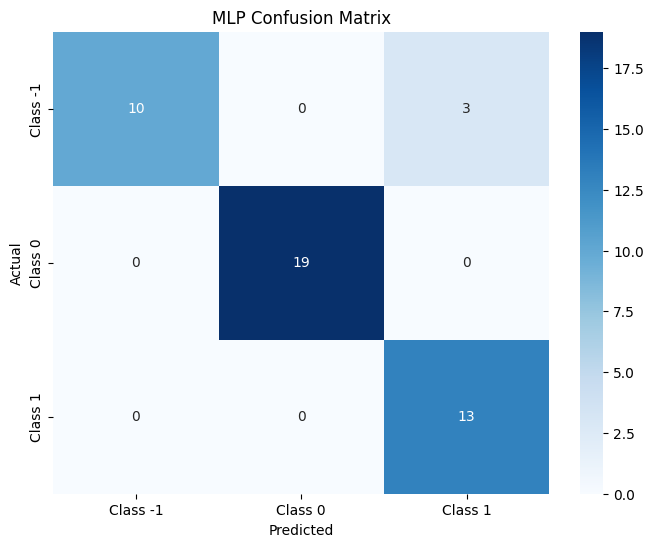

In [30]:
# Confusion Matrix for MLP
cm = confusion_matrix(y_test, mlp_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class -1', 'Class 0', 'Class 1'],
            yticklabels=['Class -1', 'Class 0', 'Class 1'])
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Detailed Analysis

In [31]:
# Class-wise accuracy for MLP
unique_classes = np.unique(y_test)
for class_label in unique_classes:
    # Get indices for this class
    class_indices = np.where(y_test == class_label)[0]
    
    # Get predictions for this class
    class_true = y_test[class_indices]
    class_pred = mlp_test_pred[class_indices]
    
    # Calculate accuracy
    class_accuracy = accuracy_score(class_true, class_pred)
    
    print(f"Class {class_label} Accuracy: {class_accuracy * 100:.2f}% ({np.sum(class_true == class_pred)}/{len(class_true)})")

Class -1 Accuracy: 76.92% (10/13)
Class 0 Accuracy: 100.00% (19/19)
Class 1 Accuracy: 100.00% (13/13)


## Key Differences Between SLP and MLP

1. **Architecture**:
   - SLP: Single layer of weights connecting input to output
   - MLP: Multiple layers with hidden neurons allowing for non-linear decision boundaries

2. **Learning Capability**:
   - SLP: Can only learn linearly separable patterns
   - MLP: Can learn complex, non-linear patterns through backpropagation

3. **Performance**:
   - SLP: Limited performance on complex datasets like Iris
   - MLP: Significantly better performance due to its ability to model non-linear relationships

4. **Training**:
   - SLP: Simple weight update rule
   - MLP: Requires backpropagation algorithm to compute gradients

The Multi-Layer Perceptron significantly outperforms the Single-Layer Perceptron on the Iris dataset, demonstrating the power of deep learning architectures.